In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import preprocessing
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Loading the dataset and normalizing

<IPython.core.display.Javascript object>


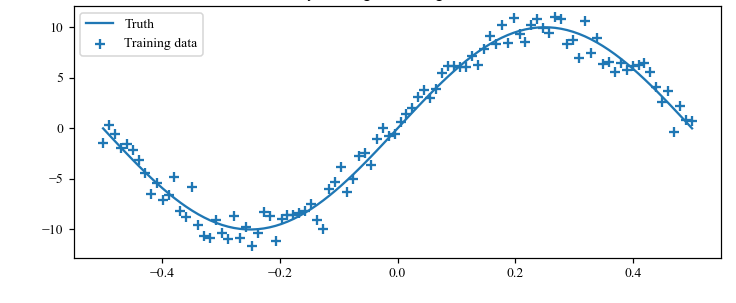

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 100
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
Y = f(X, sigma=noise)
Y_true = f(X, sigma=0.0)

cm = 1/2.54  # centimeters in inches
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(1, figsize=(17*cm, 7*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.scatter(X, Y, marker='+', label='Training data')
ax.plot(X, Y_true, label='Truth')
ax.set_title('Noisy training data and ground truth')
plt.legend();

In [3]:
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(100, 1)


Retrive features based on the modelID

In [4]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

# def normal_sp(params): 
#   return tfp.distributions.Normal(loc=params[:,0], scale=1e-3 
#                                   + tf.math.softplus(0.05 * params[:,1]))# both parameters are learnable
def normal_sp(params): 
  return tfp.distributions.Normal(loc=params, scale=noise)# both parameters are learnable

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X.shape[0] * 1.0)

inputs = tf.keras.layers.Input(shape=(X.shape[1],))

hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(32,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(1,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params)


model = Model(inputs=inputs, outputs=dist)
model.compile(Adam(learning_rate=0.001), loss=NLL) 

model_params = Model(inputs=inputs, outputs=params)
model.summary()

C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\Administrateur\anaconda3\envs\VUB\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipout  (None, 20)               80        
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 32)               1344      
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 20)               1320      
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 1)                42        
 ut)                                                         

In [5]:
epoch = 2500
batch_size = 100

model.fit(X, Y, epochs=epoch, verbose=1)

Epoch 1/2500
4/4 [==============================] - 2s 4ms/step - loss: 61.5498
Epoch 2/2500
4/4 [==============================] - 0s 4ms/step - loss: 61.5053
Epoch 3/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.4572
Epoch 4/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.3631
Epoch 5/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.2355
Epoch 6/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.2204
Epoch 7/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.2004
Epoch 8/2500
4/4 [==============================] - 0s 2ms/step - loss: 61.1133
Epoch 9/2500
4/4 [==============================] - 0s 3ms/step - loss: 61.0774
Epoch 10/2500
4/4 [==============================] - 0s 2ms/step - loss: 60.9709
Epoch 11/2500
4/4 [==============================] - 0s 2ms/step - loss: 60.9432
Epoch 12/2500
4/4 [==============================] - 0s 3ms/step - loss: 60.8569
Epoch 13/2500
4/4 [==================

4/4 [==============================] - 0s 2ms/step - loss: 37.9439
Epoch 103/2500
4/4 [==============================] - 0s 2ms/step - loss: 37.8105
Epoch 104/2500
4/4 [==============================] - 0s 2ms/step - loss: 37.8243
Epoch 105/2500
4/4 [==============================] - 0s 2ms/step - loss: 37.9796
Epoch 106/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.1849
Epoch 107/2500
4/4 [==============================] - 0s 2ms/step - loss: 37.8709
Epoch 108/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.3520
Epoch 109/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.3268
Epoch 110/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.2571
Epoch 111/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.0640
Epoch 112/2500
4/4 [==============================] - 0s 2ms/step - loss: 37.2120
Epoch 113/2500
4/4 [==============================] - 0s 2ms/step - loss: 38.1100
Epoch 114/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 33.4329
Epoch 203/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.1128
Epoch 204/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.1879
Epoch 205/2500
4/4 [==============================] - 0s 2ms/step - loss: 32.6860
Epoch 206/2500
4/4 [==============================] - 0s 2ms/step - loss: 32.7755
Epoch 207/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.1143
Epoch 208/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.0631
Epoch 209/2500
4/4 [==============================] - 0s 2ms/step - loss: 32.9979
Epoch 210/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.0989
Epoch 211/2500
4/4 [==============================] - 0s 2ms/step - loss: 32.7430
Epoch 212/2500
4/4 [==============================] - 0s 2ms/step - loss: 32.8394
Epoch 213/2500
4/4 [==============================] - 0s 2ms/step - loss: 33.1861
Epoch 214/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 28.7298
Epoch 303/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.7882
Epoch 304/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.7573
Epoch 305/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.4167
Epoch 306/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.5776
Epoch 307/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.6368
Epoch 308/2500
4/4 [==============================] - 0s 3ms/step - loss: 28.2627
Epoch 309/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.3931
Epoch 310/2500
4/4 [==============================] - 0s 3ms/step - loss: 28.3259
Epoch 311/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.2361
Epoch 312/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.8861
Epoch 313/2500
4/4 [==============================] - 0s 2ms/step - loss: 28.3483
Epoch 314/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 24.5859
Epoch 403/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.5089
Epoch 404/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.1254
Epoch 405/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.8372
Epoch 406/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.1125
Epoch 407/2500
4/4 [==============================] - 0s 2ms/step - loss: 23.8738
Epoch 408/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.1761
Epoch 409/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.2132
Epoch 410/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.6873
Epoch 411/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.2455
Epoch 412/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.1241
Epoch 413/2500
4/4 [==============================] - 0s 2ms/step - loss: 24.1791
Epoch 414/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 21.0592
Epoch 503/2500
4/4 [==============================] - 0s 2ms/step - loss: 20.9755
Epoch 504/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.2268
Epoch 505/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.4430
Epoch 506/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.2920
Epoch 507/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.4725
Epoch 508/2500
4/4 [==============================] - 0s 2ms/step - loss: 20.8627
Epoch 509/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.2843
Epoch 510/2500
4/4 [==============================] - 0s 2ms/step - loss: 20.7207
Epoch 511/2500
4/4 [==============================] - 0s 2ms/step - loss: 21.2346
Epoch 512/2500
4/4 [==============================] - 0s 2ms/step - loss: 20.6926
Epoch 513/2500
4/4 [==============================] - 0s 2ms/step - loss: 20.2303
Epoch 514/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 18.7527
Epoch 603/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.5257
Epoch 604/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.7424
Epoch 605/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.6858
Epoch 606/2500
4/4 [==============================] - 0s 2ms/step - loss: 19.0943
Epoch 607/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.5408
Epoch 608/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.8892
Epoch 609/2500
4/4 [==============================] - 0s 2ms/step - loss: 19.3659
Epoch 610/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.6995
Epoch 611/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.8914
Epoch 612/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.9077
Epoch 613/2500
4/4 [==============================] - 0s 2ms/step - loss: 18.7742
Epoch 614/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 16.8009
Epoch 703/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.0848
Epoch 704/2500
4/4 [==============================] - 0s 2ms/step - loss: 16.8809
Epoch 705/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.1518
Epoch 706/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.2617
Epoch 707/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.3316
Epoch 708/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.0756
Epoch 709/2500
4/4 [==============================] - 0s 2ms/step - loss: 16.3207
Epoch 710/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.0096
Epoch 711/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.2277
Epoch 712/2500
4/4 [==============================] - 0s 2ms/step - loss: 17.0579
Epoch 713/2500
4/4 [==============================] - 0s 2ms/step - loss: 16.9188
Epoch 714/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 15.7067
Epoch 803/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.9495
Epoch 804/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.2772
Epoch 805/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.5314
Epoch 806/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.3737
Epoch 807/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.2433
Epoch 808/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.7489
Epoch 809/2500
4/4 [==============================] - 0s 2ms/step - loss: 15.5608
Epoch 810/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.5144
Epoch 811/2500
4/4 [==============================] - 0s 1ms/step - loss: 15.9002
Epoch 812/2500
4/4 [==============================] - 0s 2ms/step - loss: 15.8674
Epoch 813/2500
4/4 [==============================] - 0s 2ms/step - loss: 15.5317
Epoch 814/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 14.8747
Epoch 903/2500
4/4 [==============================] - 0s 2ms/step - loss: 15.2528
Epoch 904/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.3918
Epoch 905/2500
4/4 [==============================] - 0s 2ms/step - loss: 15.2436
Epoch 906/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.6162
Epoch 907/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.2490
Epoch 908/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.5124
Epoch 909/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.8181
Epoch 910/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.1893
Epoch 911/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.5626
Epoch 912/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.2973
Epoch 913/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.0404
Epoch 914/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 13.0427
Epoch 1003/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.7765
Epoch 1004/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.1992
Epoch 1005/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.7864
Epoch 1006/2500
4/4 [==============================] - 0s 2ms/step - loss: 14.5011
Epoch 1007/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.5260
Epoch 1008/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.7604
Epoch 1009/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.8257
Epoch 1010/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.7942
Epoch 1011/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.7186
Epoch 1012/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.4703
Epoch 1013/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.3930
Epoch 1014/2500
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 12.7006
Epoch 1101/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.3203
Epoch 1102/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.6516
Epoch 1103/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.5862
Epoch 1104/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.9208
Epoch 1105/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.8308
Epoch 1106/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.1799
Epoch 1107/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.7237
Epoch 1108/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.3017
Epoch 1109/2500
4/4 [==============================] - 0s 2ms/step - loss: 13.2434
Epoch 1110/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.8794
Epoch 1111/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.5283
Epoch 1112/2500
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 12.4469
Epoch 1199/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.9423
Epoch 1200/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.7258
Epoch 1201/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.6324
Epoch 1202/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.9532
Epoch 1203/2500
4/4 [==============================] - 0s 3ms/step - loss: 12.4970
Epoch 1204/2500
4/4 [==============================] - 0s 3ms/step - loss: 12.0911
Epoch 1205/2500
4/4 [==============================] - 0s 3ms/step - loss: 12.7115
Epoch 1206/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.7528
Epoch 1207/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.8824
Epoch 1208/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.1872
Epoch 1209/2500
4/4 [==============================] - 0s 2ms/step - loss: 12.1994
Epoch 1210/2500
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 11.9000
Epoch 1297/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.3575
Epoch 1298/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1245
Epoch 1299/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.6734
Epoch 1300/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.7256
Epoch 1301/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.2638
Epoch 1302/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.2395
Epoch 1303/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.9361
Epoch 1304/2500
4/4 [==============================] - 0s 3ms/step - loss: 11.1984
Epoch 1305/2500
4/4 [==============================] - 0s 3ms/step - loss: 11.7477
Epoch 1306/2500
4/4 [==============================] - 0s 3ms/step - loss: 11.1245
Epoch 1307/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.3893
Epoch 1308/2500
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 10.7987
Epoch 1395/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.7407
Epoch 1396/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.2376
Epoch 1397/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1702
Epoch 1398/2500
4/4 [==============================] - 0s 3ms/step - loss: 10.8110
Epoch 1399/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.6835
Epoch 1400/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1342
Epoch 1401/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1266
Epoch 1402/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1070
Epoch 1403/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.3675
Epoch 1404/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.4374
Epoch 1405/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.2081
Epoch 1406/2500
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 10.8805
Epoch 1493/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.5360
Epoch 1494/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.1434
Epoch 1495/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.5631
Epoch 1496/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.0863
Epoch 1497/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.9935
Epoch 1498/2500
4/4 [==============================] - 0s 3ms/step - loss: 10.7975
Epoch 1499/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.7015
Epoch 1500/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.5664
Epoch 1501/2500
4/4 [==============================] - 0s 2ms/step - loss: 11.0167
Epoch 1502/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.2824
Epoch 1503/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.7920
Epoch 1504/2500
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 9.8584
Epoch 1592/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.3000
Epoch 1593/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.8767
Epoch 1594/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.9927
Epoch 1595/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.8179
Epoch 1596/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.8152
Epoch 1597/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.9771
Epoch 1598/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.2401
Epoch 1599/2500
4/4 [==============================] - 0s 3ms/step - loss: 9.9547
Epoch 1600/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.1845
Epoch 1601/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.7290
Epoch 1602/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.9042
Epoch 1603/2500
4/4 [=======

4/4 [==============================] - 0s 2ms/step - loss: 9.5318
Epoch 1691/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.6679
Epoch 1692/2500
4/4 [==============================] - 0s 3ms/step - loss: 9.5614
Epoch 1693/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.5301
Epoch 1694/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.9058
Epoch 1695/2500
4/4 [==============================] - 0s 3ms/step - loss: 9.7315
Epoch 1696/2500
4/4 [==============================] - 0s 3ms/step - loss: 9.5031
Epoch 1697/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.6882
Epoch 1698/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.4894
Epoch 1699/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.7958
Epoch 1700/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.7152
Epoch 1701/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.4686
Epoch 1702/2500
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 9.5881
Epoch 1791/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.2563
Epoch 1792/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.8546
Epoch 1793/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.7298
Epoch 1794/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.0877
Epoch 1795/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.3393
Epoch 1796/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.8475
Epoch 1797/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.4506
Epoch 1798/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.0952
Epoch 1799/2500
4/4 [==============================] - 0s 2ms/step - loss: 10.1233
Epoch 1800/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.3497
Epoch 1801/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.9481
Epoch 1802/2500
4/4 [==========

4/4 [==============================] - 0s 2ms/step - loss: 8.7693
Epoch 1891/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.1869
Epoch 1892/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.1348
Epoch 1893/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.1928
Epoch 1894/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.3239
Epoch 1895/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.8992
Epoch 1896/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.5456
Epoch 1897/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.8310
Epoch 1898/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.3914
Epoch 1899/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.4207
Epoch 1900/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.6494
Epoch 1901/2500
4/4 [==============================] - 0s 2ms/step - loss: 9.5055
Epoch 1902/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 8.8117
Epoch 1990/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.4950
Epoch 1991/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.5580
Epoch 1992/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.7323
Epoch 1993/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.6082
Epoch 1994/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.9581
Epoch 1995/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.1291
Epoch 1996/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.7496
Epoch 1997/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.9955
Epoch 1998/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.6727
Epoch 1999/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.2693
Epoch 2000/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.6635
Epoch 2001/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 7.9999
Epoch 2090/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.0794
Epoch 2091/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.4365
Epoch 2092/2500
4/4 [==============================] - 0s 3ms/step - loss: 8.3408
Epoch 2093/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.5561
Epoch 2094/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.4086
Epoch 2095/2500
4/4 [==============================] - 0s 3ms/step - loss: 7.9664
Epoch 2096/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.9374
Epoch 2097/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.1513
Epoch 2098/2500
4/4 [==============================] - 0s 3ms/step - loss: 8.2442
Epoch 2099/2500
4/4 [==============================] - 0s 3ms/step - loss: 8.1606
Epoch 2100/2500
4/4 [==============================] - 0s 3ms/step - loss: 8.3263
Epoch 2101/2500
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 8.2273
Epoch 2190/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.7016
Epoch 2191/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.9875
Epoch 2192/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.3382
Epoch 2193/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5237
Epoch 2194/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.3295
Epoch 2195/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.2524
Epoch 2196/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.2215
Epoch 2197/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.3263
Epoch 2198/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6858
Epoch 2199/2500
4/4 [==============================] - 0s 1ms/step - loss: 7.7351
Epoch 2200/2500
4/4 [==============================] - 0s 1ms/step - loss: 7.3677
Epoch 2201/2500
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 7.8218
Epoch 2290/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.7520
Epoch 2291/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6035
Epoch 2292/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.1104
Epoch 2293/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.7894
Epoch 2294/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.4683
Epoch 2295/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.1450
Epoch 2296/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5083
Epoch 2297/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.9952
Epoch 2298/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.3699
Epoch 2299/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6973
Epoch 2300/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.3513
Epoch 2301/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 7.2975
Epoch 2390/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5940
Epoch 2391/2500
4/4 [==============================] - 0s 1ms/step - loss: 8.0858
Epoch 2392/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6920
Epoch 2393/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.4724
Epoch 2394/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6545
Epoch 2395/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.8695
Epoch 2396/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5863
Epoch 2397/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.9431
Epoch 2398/2500
4/4 [==============================] - 0s 1ms/step - loss: 7.5216
Epoch 2399/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5818
Epoch 2400/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5259
Epoch 2401/2500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 6.9345
Epoch 2490/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.0513
Epoch 2491/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.2062
Epoch 2492/2500
4/4 [==============================] - 0s 2ms/step - loss: 8.2923
Epoch 2493/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.2590
Epoch 2494/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.0736
Epoch 2495/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.6100
Epoch 2496/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.0682
Epoch 2497/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.1001
Epoch 2498/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.5894
Epoch 2499/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.3068
Epoch 2500/2500
4/4 [==============================] - 0s 2ms/step - loss: 7.2333


<IPython.core.display.Javascript object>


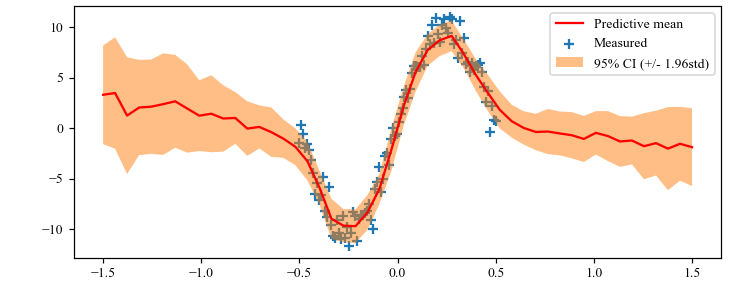

In [6]:
cm = 1/2.54  # centimeters in inches
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 9

X_test = np.linspace(-1.5, 1.5, 50).reshape(-1, 1)
# Pred = np.zeros([len(X_test), 100])
# Stdv = np.zeros([len(X_test), 100])
# for j in range(100):
#     prediction_mean, prediction_stdv, upper, lower = compute_predictions_pbnn(model, X_test)
#     Pred[:,j] = prediction_mean
#     Stdv[:,j] = prediction_stdv
# Pred = np.mean(Pred, axis=1)
# Stdv = np.std(Stdv, axis=1)

Y_test = np.zeros([len(X_test), 100])
for j in range(100):
    Y_test[:,j]= np.squeeze(model.predict(X_test))
Pred = np.mean(Y_test, axis=1)
Stdv = np.std(Y_test, axis=1)

X_test = np.squeeze(X_test)    
fig, ax = plt.subplots(1, figsize=(17*cm, 7*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.1, right=.98, top=0.98, bottom=0.15, hspace = 0.65, wspace=0.15)
ax.plot(X_test, Pred, 'r-', label='Predictive mean');
ax.scatter(X,Y, marker='+', label='Measured');
ax.fill_between(X_test,Pred+1*Stdv,Pred-1*Stdv,
                 alpha=0.5, label='95% CI (+/- 1.96std)')

ax.legend()

